# MHCII predictions for eight proteins in MTB against bovine alleles

## protiens tested: CFP10, ESAT6, Rv1789, Rv3478, Rv3615c, Rv3616c, Rv3810 and Rv3020c

see: 

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5320590/

In [2]:
import os, math, time, pickle, subprocess, io
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
import matplotlib as mpl
import pylab as plt
from IPython.display import display, HTML, IFrame
from epitopepredict import base, sequtils, plotting, peptutils, analysis

In [3]:
df = sequtils.genbank_to_dataframe( base.mtb_genome,cds=True)

In [4]:
proteins = ['Rv3874', 'Rv3875', 'Rv1789', 'Rv3478', 'Rv3615c', 'Rv3616c', 'Rv3810', 'Rv3020c']
seqs=df[df.locus_tag.isin(proteins)]
seqs.iloc[:,:6]

,type,protein_id,locus_tag,gene,db_xref,product
3764,CDS,YP_177835.1,Rv1789,PPE26,GeneID:885333,PPE family protein PPE26
6422,CDS,YP_177919.1,Rv3020c,esxS,GeneID:888946,ESAT-6 like protein EsxS
7396,CDS,YP_177976.1,Rv3478,PPE60,GeneID:888047,PE family protein PPE60
7680,CDS,NP_218132.1,Rv3615c,espC,GeneID:885770,ESX-1 secretion-associated protein EspC
7682,CDS,NP_218133.1,Rv3616c,espA,GeneID:885377,ESX-1 secretion-associated protein EspA
8098,CDS,NP_218327.1,Rv3810,pirG,GeneID:886139,cell surface protein
8232,CDS,NP_218391.1,Rv3874,esxB,GeneID:886194,ESAT-6-like protein EsxB
8234,CDS,YP_178023.1,Rv3875,esxA,GeneID:886209,ESAT-6 protein EsxA


In [21]:
##  chosen alleles should reflect population - see table 3 below from our paper
IFrame(src='https://www.microbiologyresearch.org/content/mgen/10.1099/mgen.0.000071.T3?fmt=ahah&fullscreen=true', width=600, height=400)

In [5]:
#selection of common UK bovine alleles from Farrell et al.
mhc2alleles = ['BoLA-DRB3_00101','BoLA-DRB3_00801','BoLA-DRB3_01101','BoLA-DRB3_01201',
               'BoLA-DRB3_01601','BoLA-DRB3_02201','BoLA-DRB3_02301','BoLA-DRB3_02401']
#muyu alleles
mhc2alleles = ['BoLA-DRB3_00801','BoLA-DRB3_02401','BoLA-DRB3_01001','BoLA-DRB3_01101','BoLA-DRB3_02201','BoLA-DRB3_02301',
               'BoLA-DRB3_00301','BoLA-DRB3_00501','BoLA-DRB3_00701','BoLA-DRB3_02601']

## predict binders

- can change the length to suit
- prediction data is saved in the P object

In [6]:
reload(base)
P = base.get_predictor('netmhciipan')
b = P.predict_sequences(seqs, alleles=mhc2alleles, length=11, threads=4)

/home/farrell/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


took 45.839 seconds
predictions done for 8 sequences in 10 alleles


In [7]:
print (P)

netmhciipan predictor with results in 8 sequences


## top N binders in each protein

In [8]:
b = P.get_binders(cutoff=6,cutoff_method='rank')
len(b)

480

## 'promiscuous' binders 

* top epitopes in each protein that rank high in >=n alleles
* gives an easier to handle list of peptides

In [9]:
pb=P.promiscuous_binders(binders=b,n=2,cutoff_method='rank')
pb
#save to file
pb.to_csv('prom_binders.csv',index=False)

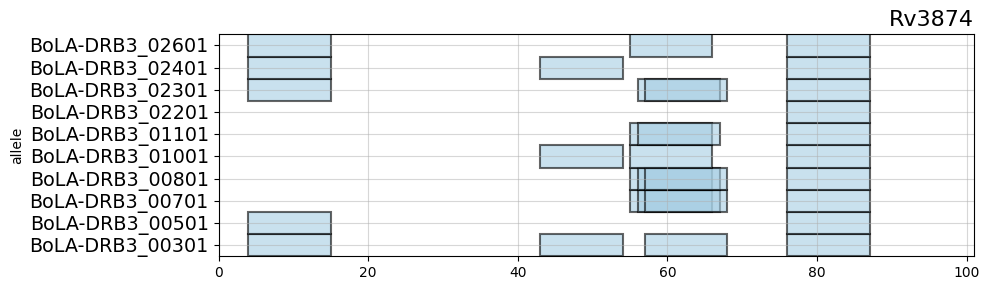

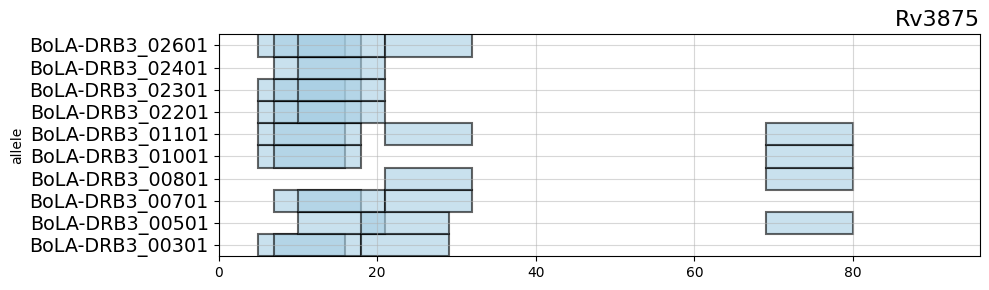

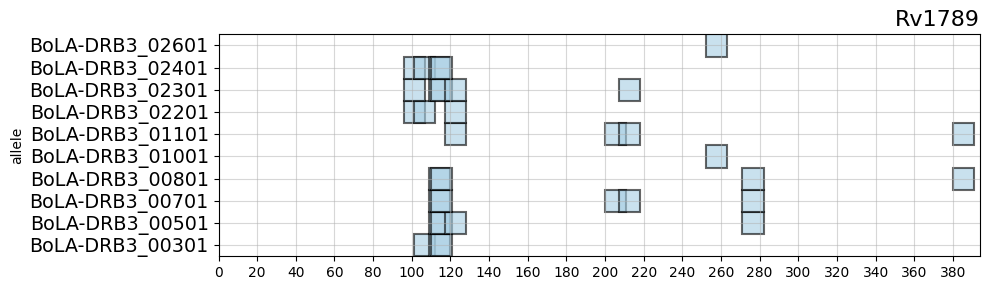

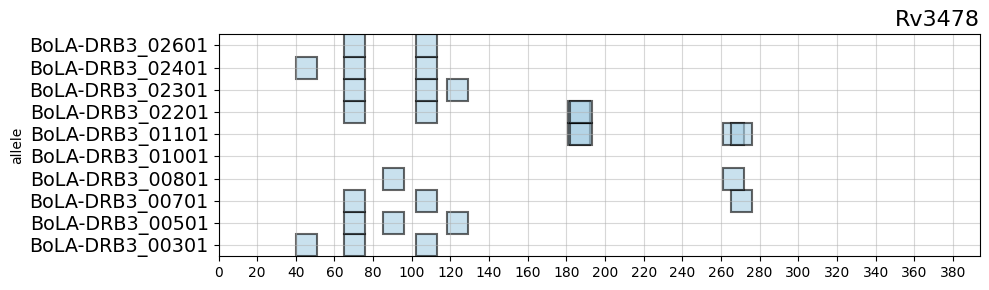

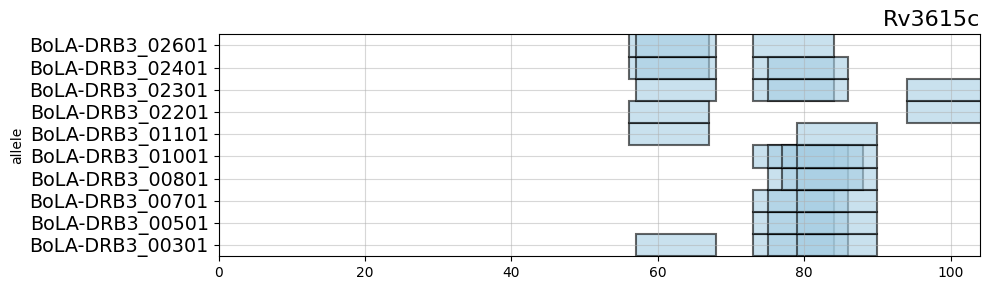

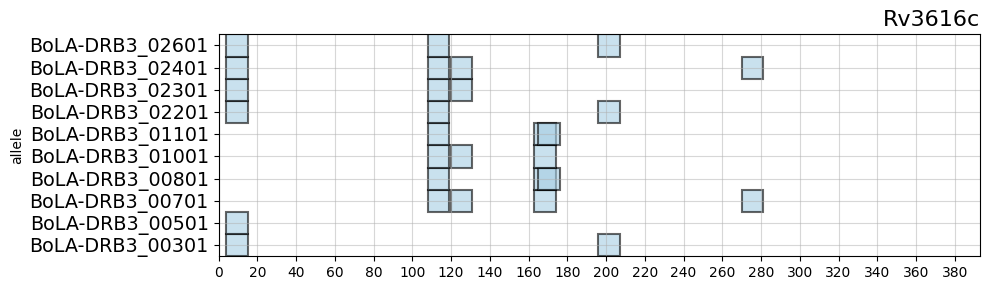

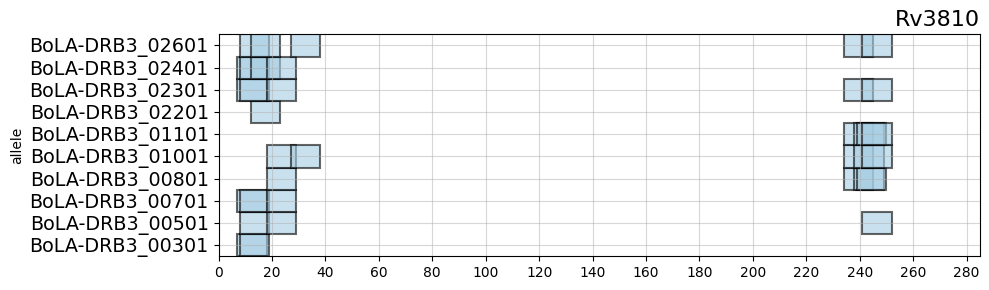

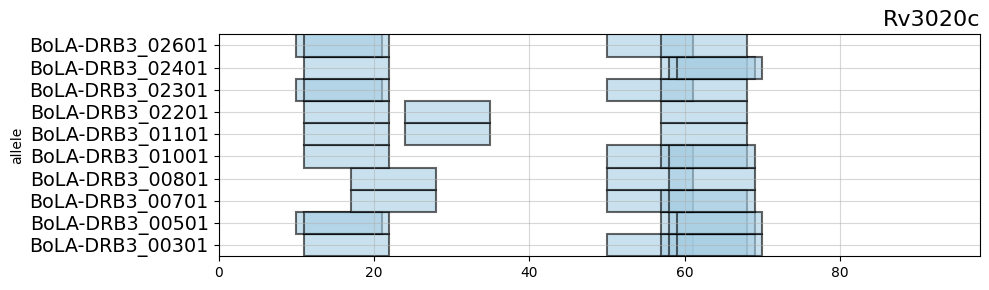

In [10]:
reload(plotting)
for name in proteins:
    ax = plotting.plot_tracks([P],name=name,cutoff=6,cutoff_method='rank',n=2,legend=False)    
    plt.tight_layout()


## binder clusters

* tries to find clusters of binders in each protein
* will give a variable number of clusters per protein

In [11]:
cl = analysis.find_clusters(pb, min_binders=2)
cl

,name,start,end,binders,length
0,Rv1789,95,127,5,32
9,Rv3810,6,37,5,31
12,Rv3875,4,31,5,27
2,Rv3020c,9,34,4,25
3,Rv3020c,49,69,4,20
10,Rv3810,233,251,4,18
7,Rv3615c,72,89,4,17
11,Rv3874,54,67,3,13
1,Rv1789,199,217,2,18
5,Rv3478,260,275,2,15


## you can also generate a set of n length peptides from the clusters

In [12]:
peptides = ep.analysis.create_nmers(cl, seqs, key='15mer', length=15, margin=2) 
peptides.to_csv('peptides_from_clusters.csv',index=False)

In [13]:
peptides

,name,start,end,binders,length,gene,locus_tag,15mer
0,Rv1789,95,127,5,32,PPE26,Rv1789,AFEAAFAATVPPPLI
1,Rv1789,95,127,5,32,PPE26,Rv1789,AANRASLMQLISTNV
2,Rv3810,6,37,5,31,pirG,Rv3810,RKLSTAMSAVAALAV
3,Rv3810,6,37,5,31,pirG,Rv3810,ASPCAYFLVYESTET
4,Rv3875,4,31,5,27,esxA,Rv3875,QWNFAGIEAAASAIQ
5,Rv3875,4,31,5,27,esxA,Rv3875,AIQGNVTSIHSLLDE
6,Rv3020c,9,34,4,25,esxS,Rv3020c,QLIASHTAFAAKAGL
7,Rv3020c,9,34,4,25,esxS,Rv3020c,AKAGLMRHTIGQAEQ
8,Rv3020c,49,69,4,20,esxS,Rv3020c,AFQGAHARFVAAAAK
9,Rv3020c,49,69,4,20,esxS,Rv3020c,HARFVAAAAKVNTLL
